## Part 1 - Building up a basic predictive model

In [1]:
#import libraries
#pip install bayesian-optimization
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from bayes_opt import BayesianOptimization
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

### 1.1.  Data cleaning and transformation

In [2]:
data = pd.read_csv("./Manhattan12.csv", skiprows=4)

In [3]:
# Dictionary to map old column names to new column names
columns_names = {'BOROUGH': 'borough',
                 'NEIGHBORHOOD': 'neighborhood',
                 'BUILDING CLASS CATEGORY': 'building_class_category',
                 'TAX CLASS AT PRESENT': 'tax_class_present',
                 'BLOCK': 'block',
                 'LOT': 'lot',
                 'EASE-MENT': 'easement',
                 'BUILDING CLASS AT PRESENT': 'building_class_present',
                 'ADDRESS': 'address',
                 'APART\nMENT\nNUMBER': 'apartment_number',
                 'ZIP CODE': 'zip_code',
                 'RESIDENTIAL UNITS': 'residential_units',
                 'COMMERCIAL UNITS': 'commercial_units',
                 'TOTAL UNITS': 'total_units',
                 'LAND SQUARE FEET': 'land_square_feet',
                 'GROSS SQUARE FEET': 'gross_square_feet',
                 'YEAR BUILT': 'year_built',
                 'TAX CLASS AT TIME OF SALE': 'tax_class_time_sale',
                 'BUILDING CLASS AT TIME OF SALE': 'building_class_time_sale',
                 'SALE\nPRICE': 'sale_price',
                 'SALE DATE': 'sale_date'}
# Rename columns using the dictionary above
data = data.rename(columns=columns_names)

In [4]:
data['sale_price'] = data['sale_price'].str.replace('$', '', regex=False).str.replace(',', '', regex=False).astype(int)

In [5]:
data['sale_date'] = pd.to_datetime(data['sale_date'], format='%d/%m/%Y')

In [6]:
data['neighborhood'] = data['neighborhood'].str.strip().replace('', np.nan)
data['building_class_category'] = data['building_class_category'].str.strip().replace('', np.nan)
data['tax_class_present'] = data['tax_class_present'].str.strip().replace('', np.nan)
data['building_class_present'] = data['building_class_present'].str.strip().replace('', np.nan)
data['building_class_time_sale'] = data['building_class_time_sale'].str.strip().replace('', np.nan)
data['address'] = data['address'].str.strip().replace('', np.nan)

In [7]:
data = data.replace(0, np.nan)


In [8]:
data = data.drop(['borough', 'easement', 'apartment_number'], axis=1)

In [9]:
q1 = data['sale_price'].quantile(0.25)
q3 = data['sale_price'].quantile(0.75)
iqr = q3 - q1
data = data[~((data['sale_price'] < (q1 - 1.5 * iqr)) | (data['sale_price'] > (q3 + 1.5 * iqr)))]


In [10]:
data['logprices'] = np.log(data['sale_price'] + 1)
data.drop('sale_price', axis=1, inplace=True)

In [11]:
# Create a MinMaxScaler object to scale numerical columns later
scaler = MinMaxScaler()
numerical_cols = ['total_units', 'land_square_feet', 'gross_square_feet', 'logprices', 'year_built',
                      'tax_class_time_sale']
data[numerical_cols] = data[numerical_cols].replace(',', '', regex=True)
data[numerical_cols] = data[numerical_cols].astype(float)
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

In [12]:
#Impute missing numeric values with mean
data.fillna(data.select_dtypes(include=[np.number]).mean(), inplace=True)


In [13]:
categorical_columns = [
        "neighborhood",
        "building_class_category",
        "tax_class_present",
        "building_class_present",
        "building_class_time_sale",
        "address"
    ]

# Impute missing categorical values with mode
for col in categorical_columns:
    data[col].fillna(data[col].mode()[0], inplace=True)

In [14]:
data.columns

Index(['neighborhood', 'building_class_category', 'tax_class_present', 'block',
       'lot', 'building_class_present', 'address', 'zip_code',
       'residential_units', 'commercial_units', 'total_units',
       'land_square_feet', 'gross_square_feet', 'year_built',
       'tax_class_time_sale', 'building_class_time_sale', 'sale_date',
       'logprices'],
      dtype='object')

### 1.2 Data Exploration

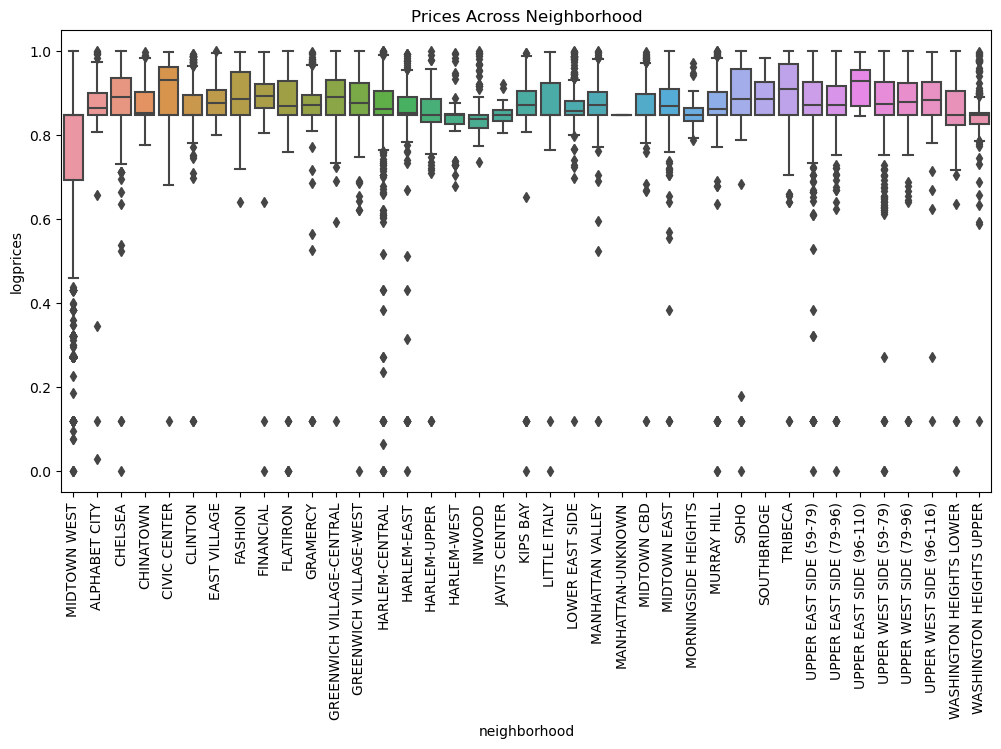

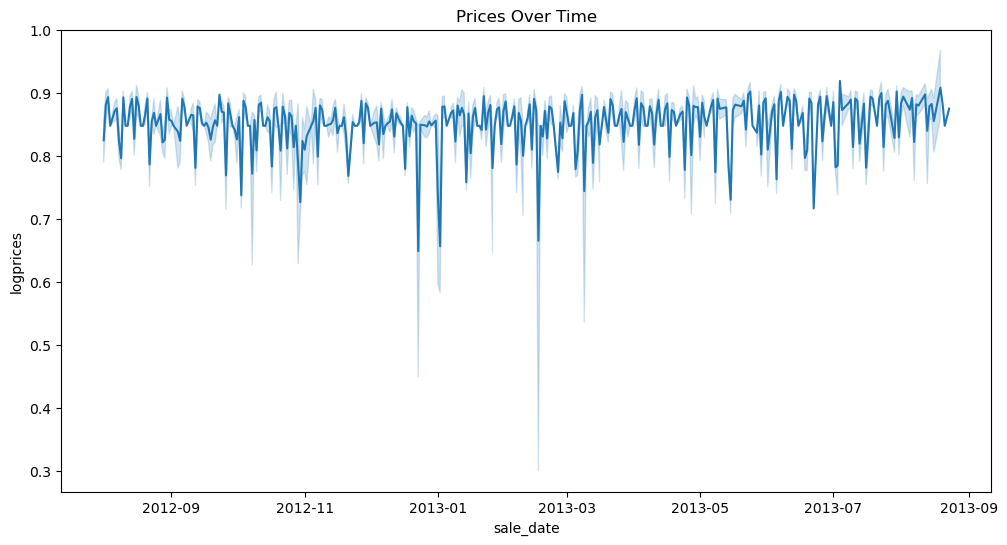

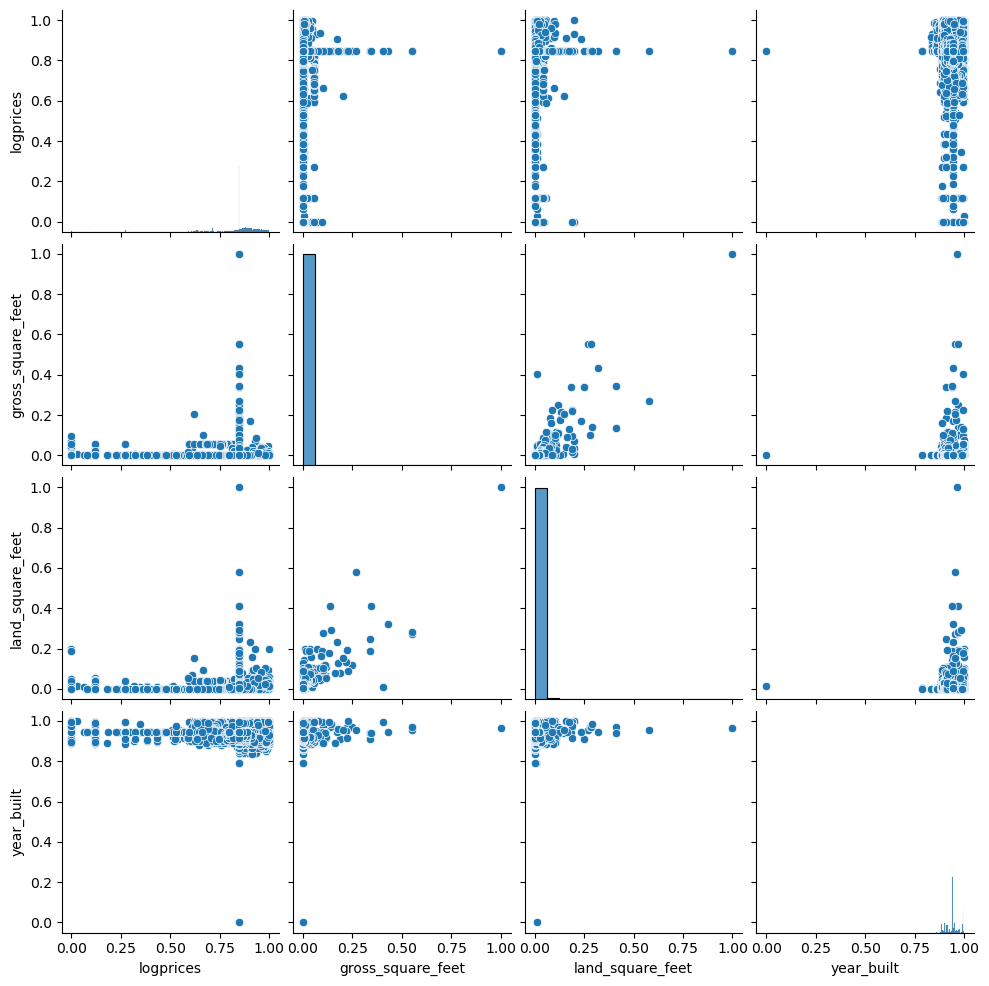

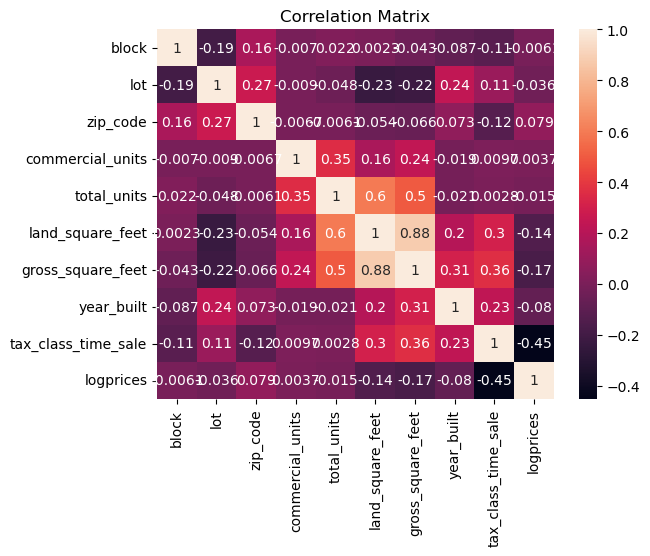

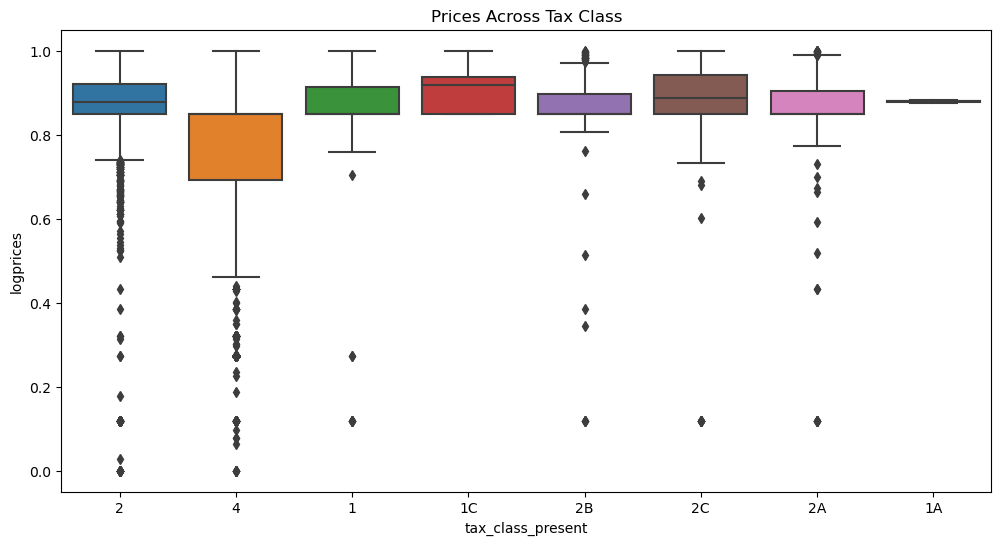

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# read the cleaned CSV file into a pandas dataframe
#df = pd.read_csv('cleaned_file_name.csv')

# visualise the prices across neighbourhood
plt.figure(figsize=(12,6))
sns.boxplot(x='neighborhood', y='logprices', data=data)
plt.xticks(rotation=90)
plt.title('Prices Across Neighborhood')
plt.show()

# visualise the prices over time
plt.figure(figsize=(12,6))
sns.lineplot(x='sale_date', y='logprices', data=data)
plt.title('Prices Over Time')
plt.show()

# show the scatter matrix plot and the correlation matrix
sns.pairplot(data, vars=['logprices', 'gross_square_feet', 'land_square_feet', 'year_built'])
plt.show()

corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True)
plt.title('Correlation Matrix')
plt.show()

# any further plots to demonstrate understanding of data
plt.figure(figsize=(12,6))
sns.boxplot(x='tax_class_present', y='logprices', data=data)
plt.title('Prices Across Tax Class')
plt.show()


### 1.3. Data Exploration

Mean CV Score: -0.21347680573924888
Final Model MSE: 0.012602637941373425
R2_scores: 0.033348980739423495


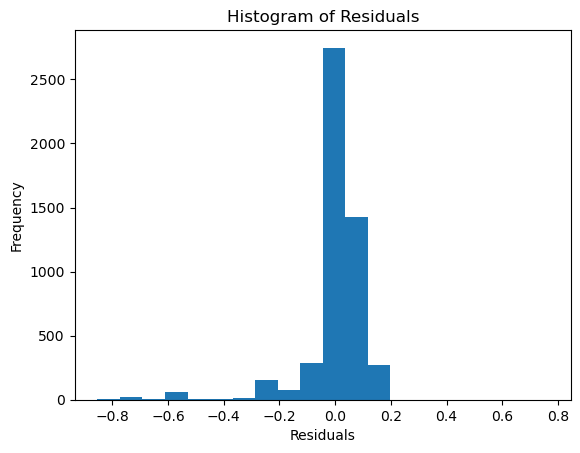

In [17]:
# Select predictor variables
x = data[['total_units', 'land_square_feet', 'gross_square_feet', 'year_built']]
#X = select_predictor_variables(manhattan_data)
# Set the target variable
y = data['logprices']
# Fit the linear model
sm.add_constant(x)

model = sm.OLS(y, x).fit()
# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)
# Build the linear regression model on the training data
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)# Make predictions on the test set using the trained model
y_pred = lr_model.predict(x_test)
# Calculate the residuals as the difference between the actual values (y_test) and predicted values (y_pred):
residuals = y_test - y_pred
# Calculate the cross-validation score for the linear regression model
cv_scores = cross_val_score(lr_model, x, y, cv=10)
# Print the mean cross-validation scores
print("Mean CV Score:", cv_scores.mean())
# print the mean squared score
print(f"Final Model MSE: {mean_squared_error(y_test, y_pred)}")
print(f"R2_scores: {r2_score(y_test, y_pred)}")
# Plot a histogram of the residuals.
plt.hist(residuals, bins=20)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

##  Part 2 - Improved model


In [18]:
# Dictionary to map old column names to new column names
data = pd.read_csv("./Manhattan12.csv", skiprows=4)
columns_names = {'BOROUGH': 'borough',
                 'NEIGHBORHOOD': 'neighborhood',
                 'BUILDING CLASS CATEGORY': 'building_class_category',
                 'TAX CLASS AT PRESENT': 'tax_class_present',
                 'BLOCK': 'block',
                 'LOT': 'lot',
                 'EASE-MENT': 'easement',
                 'BUILDING CLASS AT PRESENT': 'building_class_present',
                 'ADDRESS': 'address',
                 'APART\nMENT\nNUMBER': 'apartment_number',
                 'ZIP CODE': 'zip_code',
                 'RESIDENTIAL UNITS': 'residential_units',
                 'COMMERCIAL UNITS': 'commercial_units',
                 'TOTAL UNITS': 'total_units',
                 'LAND SQUARE FEET': 'land_square_feet',
                 'GROSS SQUARE FEET': 'gross_square_feet',
                 'YEAR BUILT': 'year_built',
                 'TAX CLASS AT TIME OF SALE': 'tax_class_time_sale',
                 'BUILDING CLASS AT TIME OF SALE': 'building_class_time_sale',
                 'SALE\nPRICE': 'sale_price',
                 'SALE DATE': 'sale_date'}
# Rename columns using the dictionary above
data = data.rename(columns=columns_names)
data['sale_price'] = data['sale_price'].str.replace('$', '', regex=False).str.replace(',', '', regex=False).astype(int)
data['sale_date'] = pd.to_datetime(data['sale_date'], format='%d/%m/%Y')
data['neighborhood'] = data['neighborhood'].str.strip().replace('', np.nan)
data['building_class_category'] = data['building_class_category'].str.strip().replace('', np.nan)
data['tax_class_present'] = data['tax_class_present'].str.strip().replace('', np.nan)
data['building_class_present'] = data['building_class_present'].str.strip().replace('', np.nan)
data['building_class_time_sale'] = data['building_class_time_sale'].str.strip().replace('', np.nan)
data['address'] = data['address'].str.strip().replace('', np.nan)
data = data.replace(0, np.nan)

# Create a MinMaxScaler object to scale numerical columns later
scaler = MinMaxScaler()
numerical_cols = ['total_units', 'land_square_feet', 'gross_square_feet', 'sale_price', 'year_built',
                      'tax_class_time_sale']
data[numerical_cols] = data[numerical_cols].replace(',', '', regex=True)
data[numerical_cols] = data[numerical_cols].astype(float)
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])
#Impute missing numeric values with mean
data.fillna(data.select_dtypes(include=[np.number]).mean(), inplace=True)

categorical_columns = [
        "neighborhood",
        "building_class_category",
        "tax_class_present",
        "building_class_present",
        "building_class_time_sale",
        "address"
    ]

# Impute missing categorical values with mode
for col in categorical_columns:
    data[col].fillna(data[col].mode()[0], inplace=True)

In [19]:
# Split data into x and y
x = data.select_dtypes(include=np.number).drop('sale_price', axis=1)
y = data['sale_price']

# Define estimator (linear regression)
estimator = LinearRegression()

# Define RFE
rfe = RFE(estimator, n_features_to_select=5)

# Fit RFE to data
rfe.fit(x, y)
selected_features_list = x.columns[rfe.support_].tolist()

In [20]:
print(f"The selected predictors choosen are: {selected_features_list}")


The selected predictors choosen are: ['total_units', 'land_square_feet', 'gross_square_feet', 'year_built', 'tax_class_time_sale']


In [32]:
# Select the features to use in the model
x = data[selected_features_list]
y = data['sale_price']

# Split the data into training and test sets
x_train,x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# Define the search space for the hyperparameters
pbounds = {'n_estimators': (10, 200),
           'max_depth': (2, 20)}

model = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42)
cv_scores = cross_val_score(model, x_train, y_train, cv=5)

# Run the Bayesian Optimization process
optimizer = BayesianOptimization(
        f=cv_scores.mean(),
        pbounds=pbounds,
        random_state=42,
    )

print("\nFine tuning hyper-parameters..............")
# Perform the optimization
optimizer.maximize(init_points=0, n_iter=20)

# Print the best hyperparameters and the corresponding CV score
best_params = optimizer.max['params']
best_cv_score = optimizer.max['target']
print("\nBest Hyperparameters:", best_params)
print("Best CV Score:", best_cv_score)

# Train the final model with the best hyperparameters
final_model, final_mse, y_pred = random_forest_regression(x, y_train, x_test, y_test,
                                                          n_estimators=int(best_params['n_estimators']),
                                                          max_depth=int(best_params['max_depth']))

mse = mean_squared_error(y_test, y_pred)
regression_residuals_plot(y_test, y_pred)
print("Final Model MSE:", mse)


Fine tuning hyper-parameters..............
|   iter    |  target   | max_depth | n_esti... |
-------------------------------------------------


TypeError: 'numpy.float64' object is not callable

In [22]:
# Create a KMeans object with the following hyperparameters
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
# Fit the KMeans object to the data
kmeans.fit(data.select_dtypes(include=np.number))


KMeans(n_clusters=3, random_state=0)

In [23]:
def visualize_clusters(data, kmeans_labels, x_var, y_var, title, xlabel, ylabel):
    sns.scatterplot(x=data[x_var], y=data[y_var], hue=kmeans_labels, palette='Set1')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

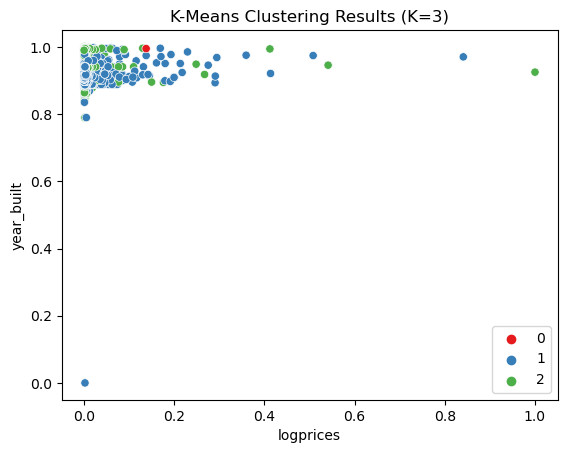

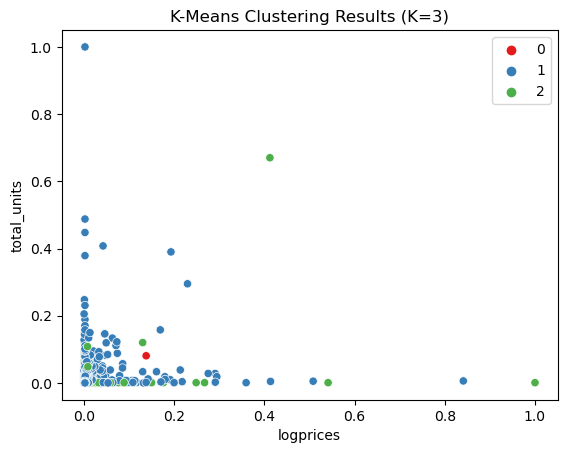

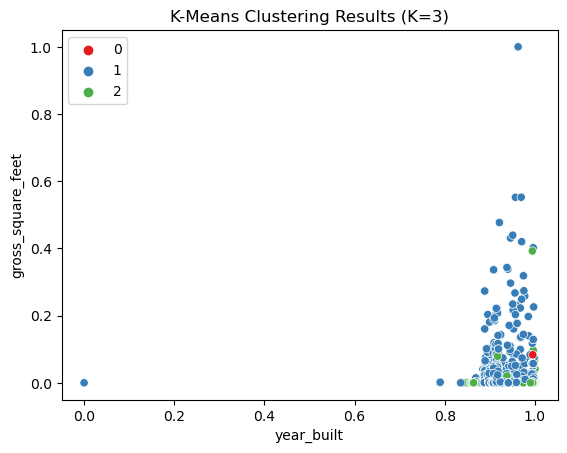

In [24]:
# Visualize clusters with 'logprices' and 'year_built'
visualize_clusters(data, kmeans.labels_, 'sale_price', 'year_built', 'K-Means Clustering Results (K=3)',
                   'logprices', 'year_built')

# Visualize clusters with 'logprices' and 'total_units'
visualize_clusters(data, kmeans.labels_, 'sale_price', 'total_units', 'K-Means Clustering Results (K=3)',
                   'logprices', 'total_units')

# Visualize clusters with 'year_built' and 'gross_square_feet'
visualize_clusters(data, kmeans.labels_, 'year_built', 'gross_square_feet', 'K-Means Clustering Results (K=3)',
                   'year_built', 'gross_square_feet')

In [25]:
def create_cluster_dataframes(data, cluster_labels):
    
    data_numeric = data.select_dtypes(include=np.number)
    data_numeric['cluster'] = cluster_labels

    cluster_dataframes = []
    num_clusters = len(set(cluster_labels))

    for i in range(num_clusters):
        cluster_data = data_numeric[data_numeric['cluster'] == i]
        cluster_dataframes.append(cluster_data)

    return cluster_dataframes


def split_and_train_clusters(cluster_dataframes, target='sale_price'):
    
    x_train_list, x_test_list, y_train_list, y_test_list, lr_models = [], [], [], [], []

    for cluster_df in cluster_dataframes:
        x = cluster_df.drop([target, 'cluster'], axis=1)
        y = cluster_df[target]
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.8, random_state=42)
        lr_model = LinearRegression()
        lr_model.fit(x_train, y_train)
        x_train_list.append(x_train)
        x_test_list.append(x_test)
        y_train_list.append(y_train)
        y_test_list.append(y_test)
        lr_models.append(lr_model)

    return x_train_list, x_test_list, y_train_list, y_test_list, lr_models


def evaluate_cluster_models(lr_models, x_test_list, y_test_list):
    

    mse_list, mae_list = [], []

    for i, lr_model in enumerate(lr_models):
        y_pred = lr_model.predict(x_test_list[i])
        mse_list.append(mean_squared_error(y_test_list[i], y_pred))
        mae_list.append(mean_absolute_error(y_test_list[i], y_pred))

    return mse_list, mae_list


def compare_models_graphically(data, cluster_models, x_test_list, y_test_list):
    

    # Split the entire dataset into training and testing sets
    x_train = data.select_dtypes(include=np.number).drop('sale_price', axis=1)
    y = data['sale_price']
    x_train, x_test, y_train, y_test = train_test_split(x_train, y, test_size=0.8, random_state=42)

    # Train the overall linear regression model
    lr_model = LinearRegression()
    lr_model.fit(x_train, y_train)
    # Predict the test data
    y_pred = lr_model.predict(x_test)

    # Plot the overall model
    plt.scatter(y_test, y_pred, alpha=0.3, label="Overall Model")

    # Plot the cluster-based models
    for i in range(len(cluster_models)):
        y_pred_cluster = cluster_models[i].predict(x_test_list[i])
        plt.scatter(y_test_list[i], y_pred_cluster, alpha=0.3, label=f"Cluster {i}")

    # Add diagonal line
    min_value = min(data['sale_price'])
    max_value = max(data['sale_price'])
    plt.plot([min_value, max_value], [min_value, max_value], 'k--', lw=2, label="Ideal Fit")

    # Customize the plot
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title('True Values vs. Predictions')
    plt.legend(loc='upper left')

    # Show the plot
    plt.show()

Cluster 0: Mean Squared Error = 0.0000, Mean Absolute Error = 0.0008
Cluster 1: Mean Squared Error = 0.0002, Mean Absolute Error = 0.0026
Cluster 2: Mean Squared Error = 0.0001, Mean Absolute Error = 0.0011


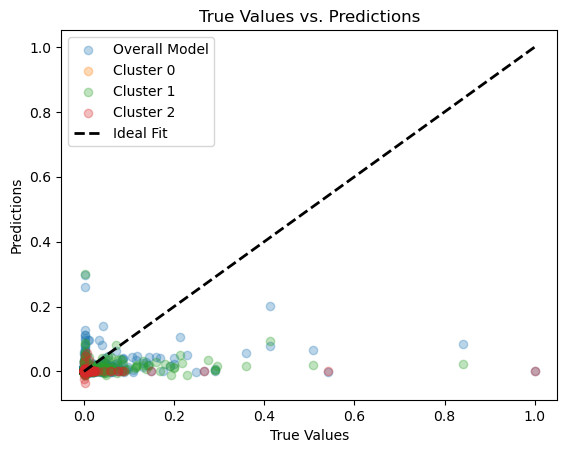

In [26]:
# Add cluster labels to the dataset and create separate dataframes for each cluster
cluster_dataframes = create_cluster_dataframes(data, kmeans.labels_)

# Split the data and train linear regression models for each cluster
X_train_list, X_test_list, y_train_list, y_test_list, lr_models = split_and_train_clusters(cluster_dataframes)

# Evaluate the models for each cluster
mse_list, mae_list = evaluate_cluster_models(lr_models, X_test_list, y_test_list)

# Print the evaluation results
for i in range(len(lr_models)):
    print(f"Cluster {i}: Mean Squared Error = {mse_list[i]:.4f}, Mean Absolute Error = {mae_list[i]:.4f}")

# Allows me to compare between to my regression model obtained in part 2.1 graphically.
compare_models_graphically(data, lr_models, X_test_list, y_test_list)
